In [296]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import random
#import sklearn.model_selection as train_test_split

# Graphic
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn Tree lib
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Bagging & Bootstrapping
from sklearn.ensemble import BaggingClassifier

# Validation
from sklearn.metrics import explained_variance_score

In [297]:
df_train = pd.read_csv("data/house-pricing.csv")
df_test = pd.read_csv("data/test.csv")
print("TRAIN SIZE: \n", df_train.shape)
print("TEST SIZE: \n", df_test.shape)

TRAIN SIZE: 
 (1460, 81)
TEST SIZE: 
 (1459, 80)


### GENERATE VALIDATION DATASET

In [298]:
def train_validation_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    np.random.seed(1)
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [299]:
train_df, validation_df = train_validation_split(df_train, test_size=0.3)
print("TRAIN SIZE: \n", train_df.shape)
print("VALIDATION SIZE: \n", validation_df.shape)

TRAIN SIZE: 
 (1022, 81)
VALIDATION SIZE: 
 (438, 81)


In [300]:
#print(df_train.info())

In [301]:
def category2Int(df):
    for feature in df.columns:
        if df[feature].dtype == 'object':
            counts = df[feature].value_counts()
            df[feature] = [counts.index.tolist().index(i) 
                        if i in counts.index.tolist() 
                        else 0 
                        for i in df[feature] ]
    return df

### CONVERTING CATEGORIES TO INTEGER

In [302]:
train_df = category2Int(df_train)
validation_df = category2Int(validation_df)
test_df = category2Int(df_test)

In [265]:
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,0,65.0,8450,0,0,0,0,0,...,0,0,0,0,0,2,2008,0,0,208500
1,2,20,0,80.0,9600,0,0,0,0,0,...,0,0,0,0,0,5,2007,0,0,181500
2,3,60,0,68.0,11250,0,0,1,0,0,...,0,0,0,0,0,9,2008,0,0,223500
3,4,70,0,60.0,9550,0,0,1,0,0,...,0,0,0,0,0,2,2006,0,2,140000
4,5,60,0,84.0,14260,0,0,1,0,0,...,0,0,0,0,0,12,2008,0,0,250000
5,6,50,0,85.0,14115,0,0,1,0,0,...,0,0,0,0,700,10,2009,0,0,143000
6,7,20,0,75.0,10084,0,0,0,0,0,...,0,0,0,0,0,8,2007,0,0,307000
7,8,60,0,NaN,10382,0,0,1,0,0,...,0,0,0,0,350,11,2009,0,0,200000
8,9,50,1,51.0,6120,0,0,0,0,0,...,0,0,0,0,0,4,2008,0,2,129900
9,10,190,0,50.0,7420,0,0,0,0,0,...,0,0,0,0,0,1,2008,0,0,118000


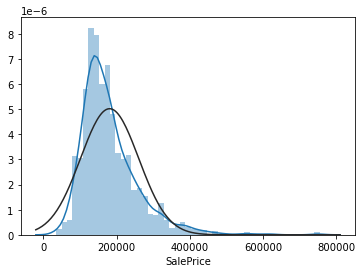

In [303]:
from scipy.stats import norm
sns.distplot(train_df['SalePrice'], fit=norm)

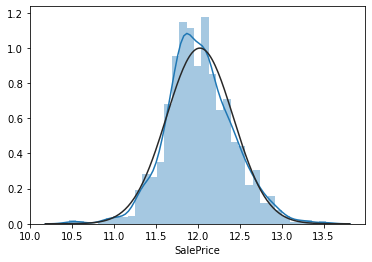

In [304]:
sns.distplot(np.log(train_df['SalePrice']), fit=norm)

#### Random Forest Regression with sklearn

In [305]:
X_train_sklearn = train_df.iloc[:, 0:80]
Y_train_sklearn = train_df['SalePrice']

rf = RandomForestRegressor(n_estimators=80, bootstrap=True)
rf.fit(train_df.iloc[:, 0:80].fillna(0), np.log(train_df[['SalePrice']]))

c:\users\doduy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### FEATURES SELECTION

In [306]:
features_importance = pd.DataFrame(rf.feature_importances_, index=train_df.iloc[:, 0:80].columns, columns=['importance'])
features_importance = features_importance.sort_values('importance', ascending=False)
print("Features importance: \n", features_importance)

Features importance: 
                importance
OverallQual  5.540055e-01
GrLivArea    1.174754e-01
TotalBsmtSF  4.648485e-02
GarageCars   3.664325e-02
1stFlrSF     2.253608e-02
...                   ...
GarageCond   1.073747e-04
PoolQC       6.782924e-05
MiscFeature  2.581326e-05
Street       5.692905e-07
Utilities    0.000000e+00

[80 rows x 1 columns]


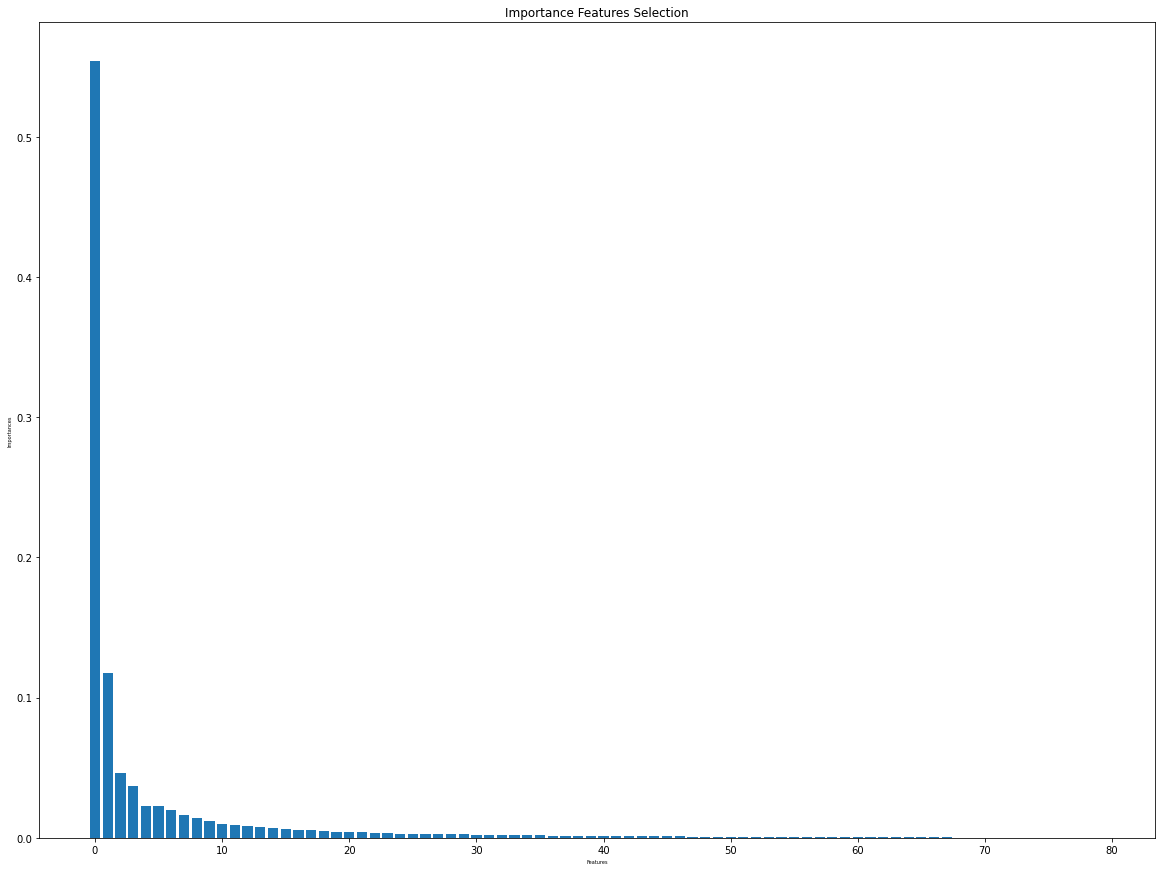

In [307]:
# Plot Features
plt.figure(figsize=(20, 15))
features = features_importance.index.tolist()

y_pos = np.arange(len(features))
plt.bar(y_pos,[float(i) for i in np.array(features_importance)[:,0]])
#fig = plt.figure(figsize=(13,6))

plt.xlabel('Features', fontsize=5)
plt.ylabel('Importances', fontsize=5)
plt.title('Importance Features Selection')
plt.show()

In [308]:
included_features = np.array(features)
included_features = included_features[0:30]
print("Importance Features for Training: \n", included_features)

Importance Features for Training: 
 ['OverallQual' 'GrLivArea' 'TotalBsmtSF' 'GarageCars' '1stFlrSF'
 'BsmtFinSF1' 'GarageArea' 'YearBuilt' 'LotArea' 'OverallCond'
 'GarageYrBlt' 'CentralAir' 'YearRemodAdd' 'GarageFinish' '2ndFlrSF'
 'Fireplaces' 'MSZoning' 'BsmtUnfSF' 'Neighborhood' 'Id' 'LotFrontage'
 'OpenPorchSF' 'MoSold' 'BsmtQual' 'WoodDeckSF' 'GarageType' 'MasVnrArea'
 'Exterior1st' 'MSSubClass' 'TotRmsAbvGrd']


In [309]:
'''
included_features = ['MoSold','YrSold','LotArea','BedroomAbvGr', # original data
                    'FullBath','HalfBath','TotRmsAbvGrd', # bathrooms and total rooms
                    'YearBuilt','YearRemodAdd', # age of the house
                    'LotShape','Utilities']
'''
X = train_df[included_features]
Y = np.log(train_df[['SalePrice']])

#print("X: \n", X.head(10))
#print("Y: \n", Y.head(10))

rf = RandomForestRegressor(n_estimators=80, bootstrap=True)
rf.fit(X.fillna(0), Y)

c:\users\doduy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Bootstrapping & Subsample

In [310]:
def bootstrappping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    return df_bootstrapped

In [311]:
def subspace(included_features, n_features):
    np.random.seed(1)
    rfeatures = random.sample(included_features.tolist(), n_features)
    return rfeatures

In [312]:
def random_forest_algorithms(n_bootstrap, n_features, train_df, n_trees, included_features):
    forest = [] # Tập các tree
    subspaces = []
    for i in range(n_trees):
        df_bootstrapping = bootstrappping(train_df, n_bootstrap)
        
        random_features = subspace(included_features, n_features)
        subspaces.append(random_features)
        # print("Random Features {0}: \n".format(i))
        # print(random_features)
        
        bsX = df_bootstrapping[random_features]
        bsY = df_bootstrapping['SalePrice']
        
        tree = DecisionTreeRegressor(max_depth=None)
        tree.fit(bsX, bsY)
        
        forest.append(tree)
    return forest, subspaces

In [313]:
dataframe_train = pd.concat([X, Y], axis=1)
dataframe_train

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,1stFlrSF,BsmtFinSF1,GarageArea,YearBuilt,LotArea,OverallCond,...,OpenPorchSF,MoSold,BsmtQual,WoodDeckSF,GarageType,MasVnrArea,Exterior1st,MSSubClass,TotRmsAbvGrd,SalePrice
0,7,1710,856,2,856,706,548,2003,8450,5,...,61,2,1,0,0,196.0,0,60,8,12.247694
1,6,1262,1262,2,1262,978,460,1976,9600,8,...,0,5,1,298,0,0.0,2,20,6,12.109011
2,7,1786,920,2,920,486,608,2001,11250,5,...,42,9,1,0,0,162.0,0,60,6,12.317167
3,7,1717,756,3,961,216,642,1915,9550,5,...,35,2,0,0,1,0.0,3,70,7,11.849398
4,8,2198,1145,3,1145,655,836,2000,14260,5,...,84,12,1,192,0,350.0,0,60,9,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,953,2,953,0,460,1999,7917,5,...,40,8,1,0,0,0.0,0,60,7,12.072541
1456,6,2073,1542,2,2073,790,500,1978,13175,6,...,0,2,1,349,0,119.0,4,20,7,12.254863
1457,7,2340,1152,1,1188,275,252,1941,9042,9,...,60,5,0,0,0,0.0,5,70,9,12.493130
1458,5,1078,1078,1,1078,49,240,1950,9717,6,...,0,4,0,366,0,0.0,2,20,5,11.864462


In [314]:
forest, subspaces = random_forest_algorithms(1000, 15, dataframe_train.fillna(0), 100, included_features)

### PREDICT FROM MODEL

In [315]:
def forest_predict(forest, subspaces, test_df):
    
    # Lưu lại các dự đoán của các Cây quyết định trong N tập test_df
    forest_predictions = []
    for i in range(len(forest)):
        tree = forest[i]
        prediction = tree.predict(test_df[subspaces[i]])
        forest_predictions.append(prediction)
    # Convert sang numpy
    forest_predictions = np.array(forest_predictions)
    
    # Trung bình cộng các dự đoán từ các Cây quyết định
    prediction = []
    for i in range(len(test_df)):
        predict_result = np.mean(forest_predictions[:, i])
        prediction.append(predict_result)
        
    print("Number of result: {0}".format(len(prediction)))
    #print("Results: \n", house_pricing_prediction)
    return prediction

test_df = test_df[included_features]
predictions = forest_predict(forest, subspaces, test_df.fillna(0)) # 1459 TEST SAMPLES
predictions = np.exp(predictions)
predictions[0]

Number of result: 1459


122291.19970925759

### VALIDATION THE MODEL

In [316]:
# Công thức: 1 - var(y - y^) / var(y)
def explained_variance(y_true, y_predict):
    score = explained_variance_score(y_true, y_predict) 
    return score

In [317]:
def validation(forest, subspaces, validation_df):
    X_validation = validation_df[included_features]
    Y_validation = validation_df['SalePrice'] # y_true
    
    y_predict = forest_predict(forest, subspaces, X_validation)
    
    '''
    print("Length of TRUE Y: ", len(Y_validation))
    print("Length of TRUE Y: ", np.log(Y_validation))
    
    print("Length of PREDICT Y: ", len(y_predict))
    print("Length of PREDICT Y: ", y_predict)
    '''
    return explained_variance(np.log(Y_validation), np.array(y_predict))

# model accuracy
scores = validation(forest, subspaces, validation_df.fillna(0))
print("Accuracy: {0} %".format(scores*100))

Number of result: 438
Accuracy: 92.24662634765345 %


In [295]:
# Sklearn model accuracy
X_validation = validation_df[included_features]
Y_validation = validation_df['SalePrice'] # y_true
sk_prediction = rf.predict(X_validation.fillna(0))
sk_score = explained_variance_score(np.log(Y_validation), sk_prediction)
print("Sklearn Accuracy: {0} %".format(sk_score*100))

Sklearn Accuracy: 97.9047839744288 %


### Test masive forest

In [321]:
n_estimators = np.arange(20, 400, 20)
for n_estimator in n_estimators:
    forest, subspaces = random_forest_algorithms(1000, 15, dataframe_train.fillna(0), n_estimator, included_features)
    
    # Validation the model
    scores = validation(forest, subspaces, validation_df.fillna(0))
    print("Number of trees: {0}".format(n_estimator))
    print("Accuracy: {0} %".format(scores*100))

Number of result: 438
Number of trees: 20
Accuracy: 91.38596936569375 %
Number of result: 438
Number of trees: 40
Accuracy: 92.01485670971167 %
Number of result: 438
Number of trees: 60
Accuracy: 91.40630784401512 %
Number of result: 438
Number of trees: 80
Accuracy: 91.79762013138321 %
Number of result: 438
Number of trees: 100
Accuracy: 91.459054540453 %
Number of result: 438
Number of trees: 120
Accuracy: 91.98266219094802 %
Number of result: 438
Number of trees: 140
Accuracy: 91.94452647366974 %
Number of result: 438
Number of trees: 160
Accuracy: 91.75503906761608 %
Number of result: 438
Number of trees: 180
Accuracy: 92.04687316199352 %
Number of result: 438
Number of trees: 200
Accuracy: 91.9748008951421 %
Number of result: 438
Number of trees: 220
Accuracy: 91.69378961892654 %
Number of result: 438
Number of trees: 240
Accuracy: 91.98044246744632 %
Number of result: 438
Number of trees: 260
Accuracy: 91.9677569983605 %
Number of result: 438
Number of trees: 280
Accuracy: 91.733